In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import imghdr
import seaborn as sns
from skimage.restoration import denoise_tv_chambolle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from tensorflow import keras
from PIL import Image
import torch
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation


### Images Count

In [3]:
def display_count(image_dir, mask_dir):
    image_count = len(os.listdir(image_dir))
    mask_count = len(os.listdir(mask_dir))

    print(f"Number of images: {image_count}")
    print(f"Number of masks: {mask_count}")

# Directories containing images and masks
image_dir = '.\Dataset\Image'
mask_dir = '.\Dataset\Mask'

# Display the count of images and masks
display_count(image_dir, mask_dir)

Number of images: 289
Number of masks: 289


### Display Random Images and Its masks

In [4]:
def plot_images_and_masks(image_paths, mask_paths):
    # Plot image and mask side by side
    plt.figure(figsize=(18, 12))

    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 2, 2*i + 1)
        plt.title('Original Image')
        plt.imshow(image_rgb)
        plt.axis('off')

        plt.subplot(3, 2, 2*i + 2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

    plt.show()

In [5]:
def plot_overlay(image_paths, mask_paths):
    # Plot overlay of image and mask
    plt.figure(figsize=(18, 12))

    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        overlay = image_rgb.copy()
        overlay[mask > 0] = (255, 0, 0)  # Red color for the mask

        plt.subplot(3, 1, i + 1)
        plt.title('Overlay')
        plt.imshow(overlay)
        plt.axis('off')

    plt.show()

def get_random_image_mask_pairs(image_dir, mask_dir, num_pairs=3):
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    image_mask_pairs = list(zip(image_files, mask_files))
    random_pairs = random.sample(image_mask_pairs, num_pairs)

    image_paths = [os.path.join(image_dir, pair[0]) for pair in random_pairs]
    mask_paths = [os.path.join(mask_dir, pair[1]) for pair in random_pairs]

    return image_paths, mask_paths


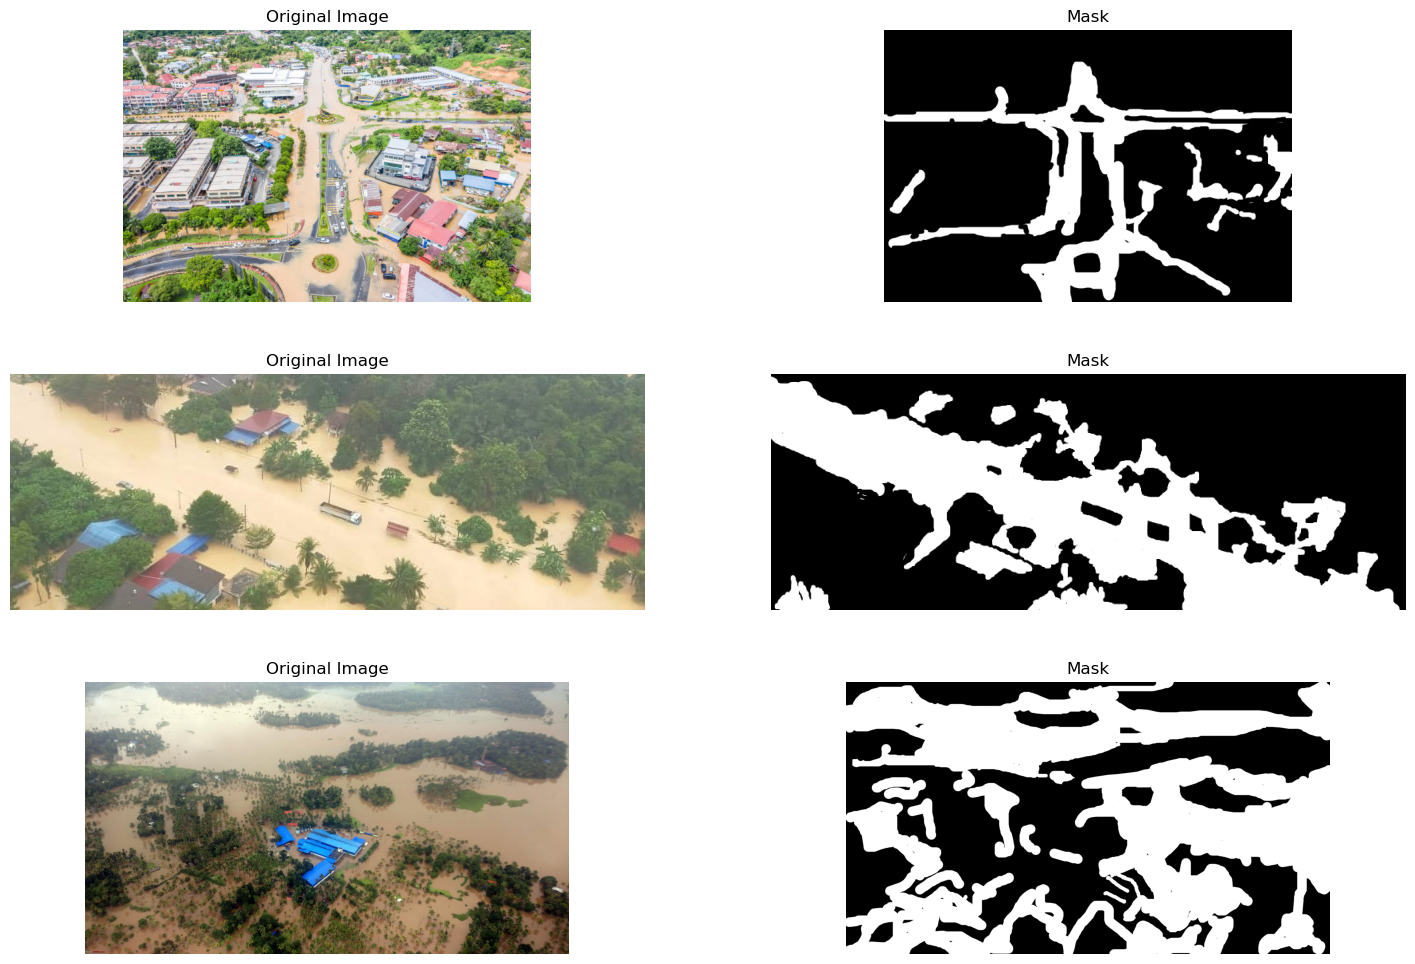

In [6]:
# Get random image-mask pairs
image_paths, mask_paths = get_random_image_mask_pairs(image_dir, mask_dir)

# Plot the images and masks
plot_images_and_masks(image_paths, mask_paths)


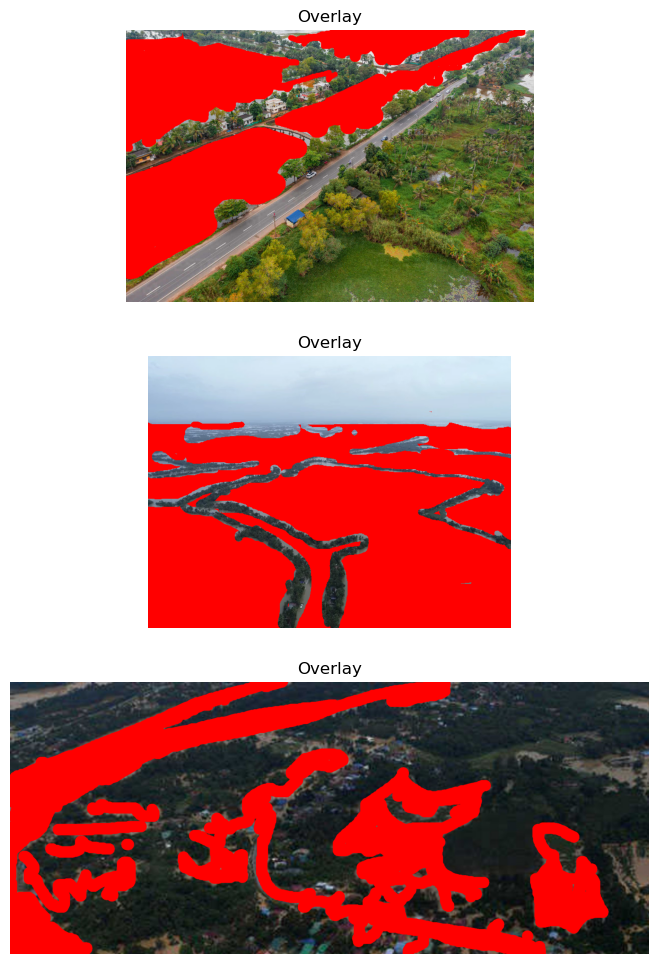

In [10]:
plot_overlay(image_paths, mask_paths)

### EDA to Display Images Dimensions and Mask Coverage

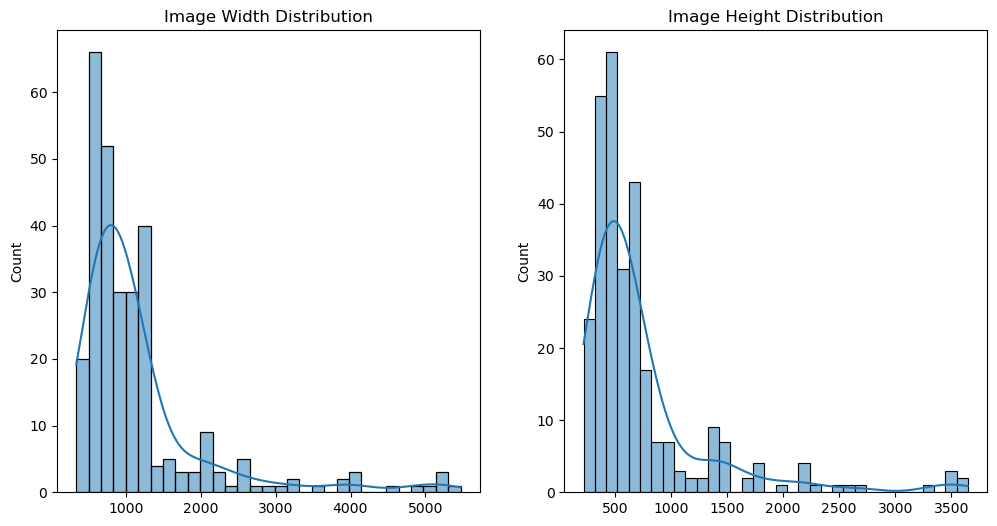

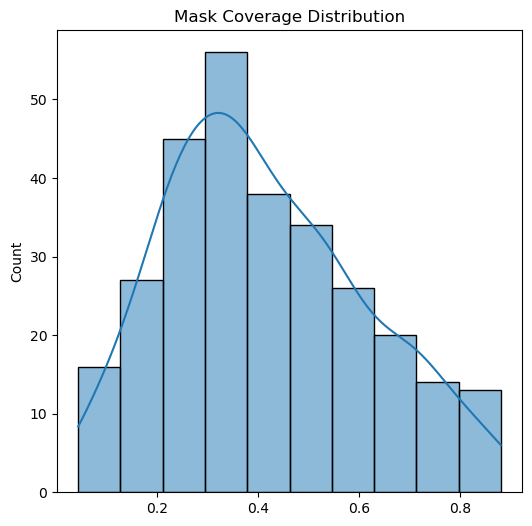

In [8]:
# Directories containing images and masks
image_dir = '.\\Dataset\\Image'
mask_dir = '.\\Dataset\\Mask'

# Get list of images and masks
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Initialize lists for image dimensions and mask coverage
image_dimensions = []
mask_coverage = []

# Analyze each image and mask
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue
    if mask is None:
        print(f"Error reading mask: {mask_path}")
        continue

    # Append image dimensions
    image_dimensions.append(image.shape[:2])

    # Calculate mask coverage
    mask_coverage.append(np.sum(mask > 0) / mask.size)

# Convert lists to arrays for easy analysis
image_dimensions = np.array(image_dimensions)
mask_coverage = np.array(mask_coverage)

# Plot image dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Image Width Distribution')
sns.histplot(image_dimensions[:, 1], kde=True)
plt.subplot(1, 2, 2)
plt.title('Image Height Distribution')
sns.histplot(image_dimensions[:, 0], kde=True)
plt.show()

# Plot mask coverage distribution
plt.figure(figsize=(6, 6))
plt.title('Mask Coverage Distribution')
sns.histplot(mask_coverage, kde=True)
plt.show()

### EDA: Distribution of Pixel intensity

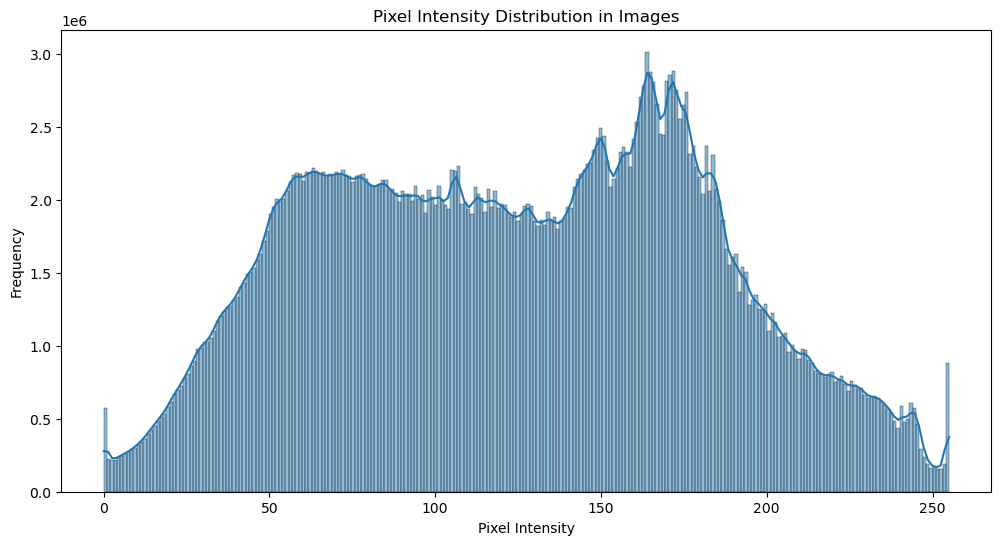

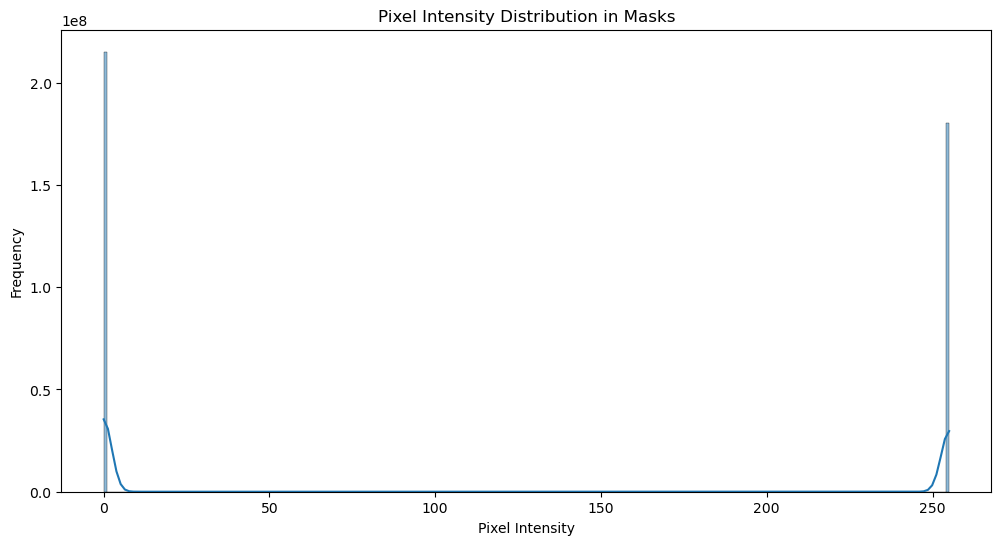

In [9]:
image_intensities = []
mask_intensities = []

# Analyze each image and mask
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale for intensity analysis
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue
    if mask is None:
        print(f"Error reading mask: {mask_path}")
        continue

    # Append pixel intensities
    image_intensities.extend(image.flatten())
    mask_intensities.extend(mask.flatten())

# Convert lists to arrays for easy analysis
image_intensities = np.array(image_intensities)
mask_intensities = np.array(mask_intensities)

# Plot pixel intensity distribution for images
plt.figure(figsize=(12, 6))
plt.title('Pixel Intensity Distribution in Images')
sns.histplot(image_intensities, bins=256, kde=True)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Plot pixel intensity distribution for masks
plt.figure(figsize=(12, 6))
plt.title('Pixel Intensity Distribution in Masks')
sns.histplot(mask_intensities, bins=256, kde=True)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### Data Preprocessing: Total Variation Denoising

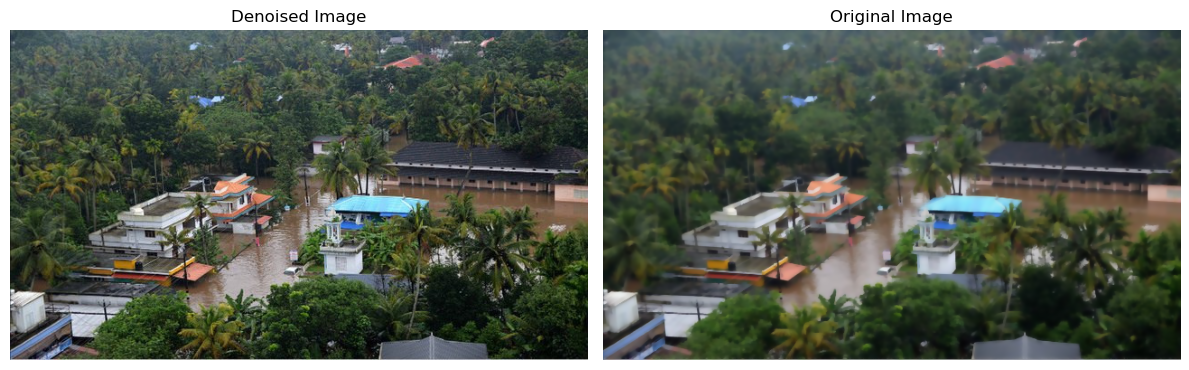

In [ ]:
# Directory containing images
image_dir = './Dataset/Image'

# Get list of images
image_files = os.listdir(image_dir)

# Select a random image file
random_image_file = random.choice(image_files)
image_path = os.path.join(image_dir, random_image_file)

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

if image is None:
    raise FileNotFoundError(f"Image not found at: {image_path}")

# Perform Total Variation denoising
denoised_image = denoise_tv_chambolle(image, weight=0.1, multichannel=True)

# Display original and denoised images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing : Applying and saving it in folder

In [ ]:
# Directory containing original images
original_image_dir = './Dataset/Image'

# Directory to save preprocessed (denoised) images
preprocessed_image_dir = './Dataset/Preprocessed'

# Create the directory if it doesn't exist
os.makedirs(preprocessed_image_dir, exist_ok=True)

# Get list of images
image_files = os.listdir(original_image_dir)

# Define denoising parameters
denoising_weight = 0.1

# Iterate through each image and denoise
for image_file in tqdm(image_files, desc='Processing Images'):
    # Construct paths
    image_path = os.path.join(original_image_dir, image_file)
    save_path = os.path.join(preprocessed_image_dir, image_file)

    # Check if the preprocessed image already exists
    if os.path.exists(save_path):
        continue

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image: {image_path}")
        continue

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform Total Variation denoising
    denoised_image = denoise_tv_chambolle(image, weight=denoising_weight, multichannel=True)

    # Convert denoised image from float to uint8
    denoised_image = (denoised_image * 255).astype(np.uint8)

    # Convert RGB back to BGR for OpenCV saving
    denoised_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2BGR)

    # Save denoised image
    cv2.imwrite(save_path, denoised_image)

print("Preprocessing completed.")


Processing Images: 100%|███████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 8956.49it/s]

Preprocessing completed.


### Unet Model

#### Without Preprocessing

In [2]:
image_dir = r"./Dataset/Image/"
mask_dir = r"./Dataset/Mask/"

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

paths = pd.DataFrame({
    "input": image_files,
    "target": mask_files
})
print(paths)

                        input                   target
0       ./Dataset/Image/1.jpg     ./Dataset/Mask/1.png
1      ./Dataset/Image/10.jpg    ./Dataset/Mask/10.png
2    ./Dataset/Image/1000.jpg  ./Dataset/Mask/1000.png
3    ./Dataset/Image/1001.jpg  ./Dataset/Mask/1001.png
4    ./Dataset/Image/1002.jpg  ./Dataset/Mask/1002.png
..                        ...                      ...
284     ./Dataset/Image/5.jpg     ./Dataset/Mask/5.png
285     ./Dataset/Image/6.jpg     ./Dataset/Mask/6.png
286     ./Dataset/Image/7.jpg     ./Dataset/Mask/7.png
287     ./Dataset/Image/8.jpg     ./Dataset/Mask/8.png
288     ./Dataset/Image/9.jpg     ./Dataset/Mask/9.png

[289 rows x 2 columns]


In [3]:
def read_image_and_mask(file_path, is_mask = False):
    try:
        image = tf.io.read_file(file_path)
        if is_mask:
            image = tf.image.decode_png(image, channels=1)
        else:
            image = tf.image.decode_jpeg(image, channels=3)

        image = tf.image.resize(image, [128, 128])
        image = tf.image.convert_image_dtype(image, tf.float32)

    except tf.errors.InvalidArgumentError as e:
        # Print out the file path causing the error
        tf.print(f"Error reading file: {file_path}")
        raise e
    return image/255

In [4]:
def create_dataset_from_dataframe(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['input'], dataframe['target']))
    dataset = dataset.map(lambda x, y: (read_image_and_mask(x, is_mask=False), read_image_and_mask(y, is_mask=True)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(16)
    return dataset

In [5]:
image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
rows_to_delete = []

for index, row in paths.iterrows():
    filepath = Path(row['input'])
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            rows_to_delete.append(index)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            rows_to_delete.append(index)

Dataset\Image\1002.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1009.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1013.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1015.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1027.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1028.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1036.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1037.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1046.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1049.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1053.jpg is not an image
Dataset\Image\1054.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1056.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1062.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1065.jpg is not an image
Dataset\Image\1068.jpg is a webp, not accepted by TensorFlow
Dataset\Image\1074.jpg is a webp, not accepted by TensorFlow
Dataset

In [6]:
paths = paths.drop(rows_to_delete).reset_index()
len(paths)

232

In [7]:
train_df, remaining_df = train_test_split(paths, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

train_dataset = create_dataset_from_dataframe(train_df)
val_dataset = create_dataset_from_dataframe(val_df)
test_dataset = create_dataset_from_dataframe(test_df)

In [ ]:
model = sm.Unet('efficientnetb2',
                input_shape = (128,128,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-5),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [iou_score],
)

history = model.fit(train_dataset, validation_data = val_dataset,
                    epochs = 50)

Epoch 1/50
11/11 [==============================] - 34s 962ms/step - loss: 0.7817 - iou_score: 0.3096 - val_loss: 0.7271 - val_iou_score: 0.2766
Epoch 2/50
11/11 [==============================] - 3s 242ms/step - loss: 0.7305 - iou_score: 0.3371 - val_loss: 0.7061 - val_iou_score: 0.3265
Epoch 3/50
11/11 [==============================] - 3s 251ms/step - loss: 0.6880 - iou_score: 0.3496 - val_loss: 0.6856 - val_iou_score: 0.3316
Epoch 4/50
11/11 [==============================] - 3s 241ms/step - loss: 0.6521 - iou_score: 0.3678 - val_loss: 0.6632 - val_iou_score: 0.3219
Epoch 5/50
11/11 [==============================] - 3s 241ms/step - loss: 0.6199 - iou_score: 0.3852 - val_loss: 0.6361 - val_iou_score: 0.3383
Epoch 6/50
11/11 [==============================] - 3s 246ms/step - loss: 0.5943 - iou_score: 0.3927 - val_loss: 0.6066 - val_iou_score: 0.3451
Epoch 7/50
11/11 [==============================] - 3s 239ms/step - loss: 0.5690 - iou_score: 0.4095 - val_loss: 0.5818 - val_iou_score

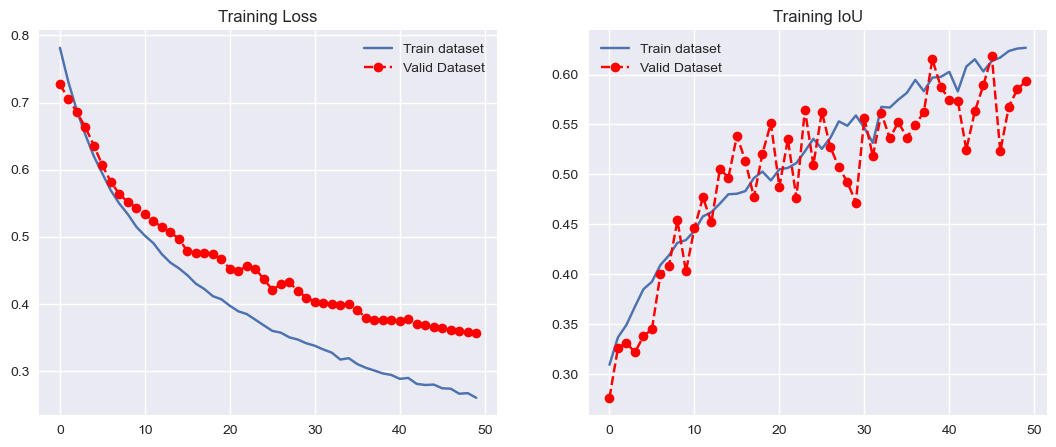

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.plot(history.history['loss'], label = 'Train dataset')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Valid Dataset')
plt.legend()

plt.subplot(1,2,2)
plt.title('Training IoU')
plt.plot(history.history['iou_score'], label = 'Train dataset')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Valid Dataset')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 49ms/step - loss: 0.3427 - iou_score: 0.5943


[0.3427017033100128, 0.5942943096160889]

### With preprocessing

In [19]:
image_dir = r"./Dataset/Preprocessed/"
mask_dir = r"./Dataset/Mask/"

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

paths = pd.DataFrame({
    "input": image_files,
    "target": mask_files
})
print(paths)

image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
rows_to_delete = []

for index, row in paths.iterrows():
    filepath = Path(row['input'])
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            rows_to_delete.append(index)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            rows_to_delete.append(index)
paths = paths.drop(rows_to_delete).reset_index()
len(paths)

                               input                   target
0       ./Dataset/Preprocessed/1.jpg     ./Dataset/Mask/1.png
1      ./Dataset/Preprocessed/10.jpg    ./Dataset/Mask/10.png
2    ./Dataset/Preprocessed/1000.jpg  ./Dataset/Mask/1000.png
3    ./Dataset/Preprocessed/1001.jpg  ./Dataset/Mask/1001.png
4    ./Dataset/Preprocessed/1002.jpg  ./Dataset/Mask/1002.png
..                               ...                      ...
284     ./Dataset/Preprocessed/5.jpg     ./Dataset/Mask/5.png
285     ./Dataset/Preprocessed/6.jpg     ./Dataset/Mask/6.png
286     ./Dataset/Preprocessed/7.jpg     ./Dataset/Mask/7.png
287     ./Dataset/Preprocessed/8.jpg     ./Dataset/Mask/8.png
288     ./Dataset/Preprocessed/9.jpg     ./Dataset/Mask/9.png

[289 rows x 2 columns]


289

In [20]:
train_df, remaining_df = train_test_split(paths, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

train_dataset = create_dataset_from_dataframe(train_df)
val_dataset = create_dataset_from_dataframe(val_df)
test_dataset = create_dataset_from_dataframe(test_df)

In [22]:
model = sm.Unet('efficientnetb2',
                input_shape = (128,128,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-5),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [iou_score],
)

history = model.fit(train_dataset, validation_data = val_dataset,
                    epochs = 50)

Epoch 1/50
13/13 [==============================] - 23s 817ms/step - loss: 0.9182 - iou_score: 0.3450 - val_loss: 1.4367 - val_iou_score: 0.3851
Epoch 2/50
13/13 [==============================] - 4s 297ms/step - loss: 0.8526 - iou_score: 0.3638 - val_loss: 1.1410 - val_iou_score: 0.3724
Epoch 3/50
13/13 [==============================] - 4s 306ms/step - loss: 0.7948 - iou_score: 0.3807 - val_loss: 0.9462 - val_iou_score: 0.3631
Epoch 4/50
13/13 [==============================] - 4s 304ms/step - loss: 0.7448 - iou_score: 0.3963 - val_loss: 0.8216 - val_iou_score: 0.3554
Epoch 5/50
13/13 [==============================] - 4s 295ms/step - loss: 0.7015 - iou_score: 0.4075 - val_loss: 0.7375 - val_iou_score: 0.3636
Epoch 6/50
13/13 [==============================] - 4s 292ms/step - loss: 0.6670 - iou_score: 0.4160 - val_loss: 0.6835 - val_iou_score: 0.3861
Epoch 7/50
13/13 [==============================] - 4s 291ms/step - loss: 0.6361 - iou_score: 0.4251 - val_loss: 0.6512 - val_iou_score

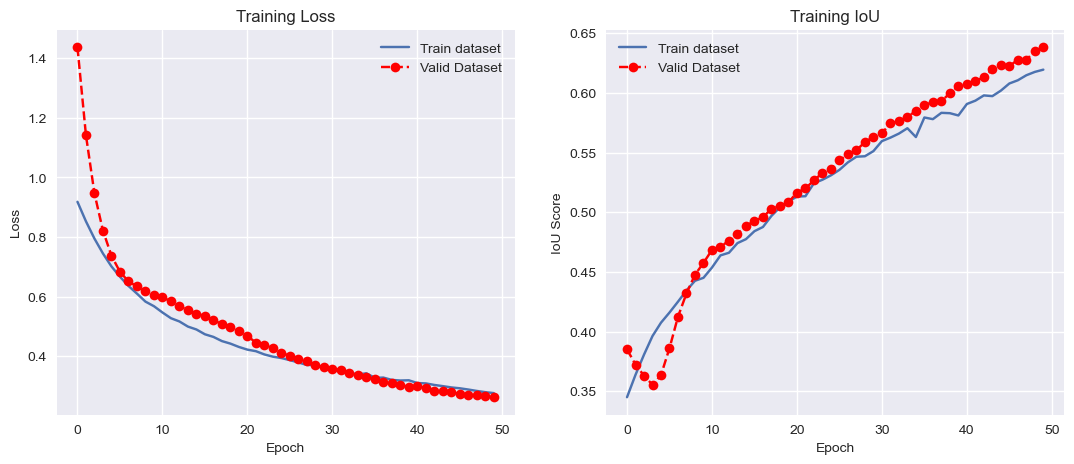

In [13]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.plot(history.history['loss'], label = 'Train dataset')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Valid Dataset')
plt.legend()

plt.subplot(1,2,2)
plt.title('Training IoU')
plt.plot(history.history['iou_score'], label = 'Train dataset')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Valid Dataset')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 61ms/step - loss: 0.2562 - iou_score: 0.6732


[0.2561837434768677, 0.6731951236724854]

### Generating Mask from UNET+ Denosing model

1/1 [==============================] - 2s 2s/step


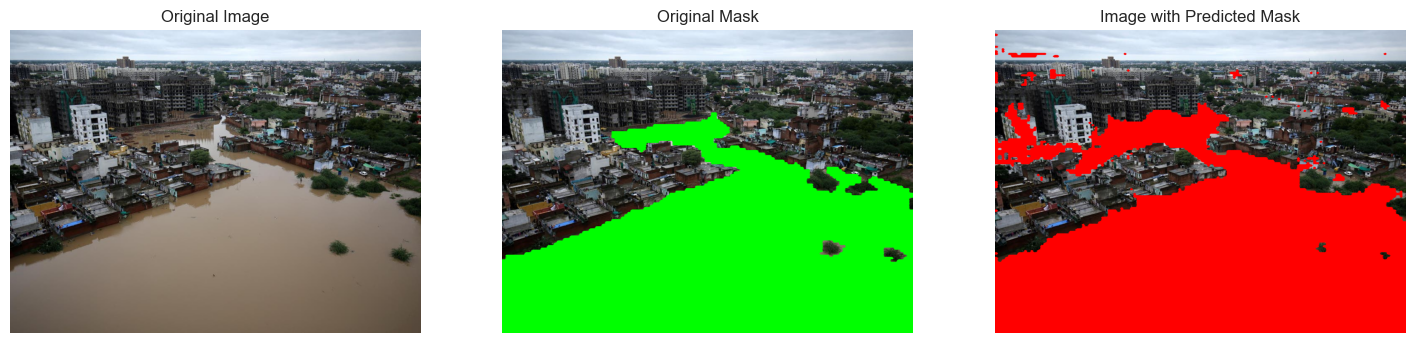

In [24]:
def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (128, 128))
    image_resized = image_resized / 255.0  # Normalize to [0, 1]
    return image, image_resized

def denoise_image(image):
    """Apply denoising to the image."""
    return denoise_tv_chambolle(image, weight=0.1, multichannel=True)

def predict_mask(image):
    """Predict the mask for the image."""
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    predicted_mask = model.predict(image)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarize mask
    return predicted_mask

def plot_images(original_image, original_mask, predicted_mask):
    """Plot the original image, original mask, and the overlay of the predicted mask."""
    # Resize the original mask to match the original image size
    original_mask_resized = cv2.resize(original_mask, (original_image.shape[1], original_image.shape[0]))

    # Create overlay for predicted mask
    overlay_predicted = original_image.copy()
    predicted_mask_resized = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))
    overlay_predicted[predicted_mask_resized == 1] = [255, 0, 0]  # Red color for mask

    # Create overlay for original mask
    overlay_original = original_image.copy()
    overlay_original[original_mask_resized == 1] = [0, 255, 0]  # Green color for original mask

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Original Mask")
    plt.imshow(overlay_original)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Image with Predicted Mask")
    plt.imshow(overlay_predicted)
    plt.axis("off")

    plt.show()

# Path to the input image and original mask
image_path = './Dataset/Image/1001.jpg'
mask_path = './Dataset/Mask/1001.png'  # Assuming mask is in PNG format

# Load and preprocess the input image
original_image, preprocessed_image = preprocess_image(image_path)

# Load the original mask
original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
original_mask = cv2.resize(original_mask, (128, 128))
original_mask = (original_mask > 0).astype(np.uint8)  # Binarize mask

# Apply denoising to the input image
denoised_image = denoise_image(preprocessed_image)

# Predict the mask using the trained model
predicted_mask = predict_mask(denoised_image)

# Overlay the mask on the original image and plot the results
plot_images(original_image, original_mask, predicted_mask)

### Mask transformer: without preprocessing

In [8]:
# IoU Calculation Function
def calculate_iou(predicted, ground_truth, num_classes=2):
    iou_scores = []
    for cls in range(num_classes):
        intersection = np.logical_and(predicted == cls, ground_truth == cls).sum()
        union = np.logical_or(predicted == cls, ground_truth == cls).sum()
        if union == 0:
            iou_scores.append(float('nan'))  # if there's no ground truth or predicted pixels for this class
        else:
            iou_scores.append(intersection / union)
    return np.nanmean(iou_scores)  # mean IoU across classes


In [9]:
class FloodDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = [img for img in os.listdir(image_dir) if img.endswith('.jpg') and os.path.isfile(os.path.join(mask_dir, img.replace('.jpg', '.png')))]

        print(f"Found {len(self.images)} images with corresponding masks.")
        if len(self.images) == 0:
            print("Warning: No images with corresponding masks were found.")
        else:
            # Print the first few image and mask file names for verification
            print("Sample of image files:", self.images[:5])
            print("Sample of corresponding mask files:", [os.path.join(mask_dir, img.replace('.jpg', '.png')) for img in self.images[:5]])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [13]:
# Parameters
num_epochs = 20
learning_rate = 5e-5
batch_size = 4

# Dataset and Dataloader
image_dir = "./Dataset/Image"
mask_dir = "./Dataset/Mask"

print("Checking directories...")
print(f"Images directory: {os.path.exists(image_dir)}, contains {len(os.listdir(image_dir))} files")
print(f"Masks directory: {os.path.exists(mask_dir)}, contains {len(os.listdir(mask_dir))} files")

# Define the transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = FloodDataset(image_dir=image_dir, mask_dir=mask_dir, image_transform=image_transform, mask_transform=mask_transform)

# Split dataset into training and validation sets
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load the pretrained model
processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-tiny-ade")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-ade")

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Checking directories...
Images directory: True, contains 289 files
Masks directory: True, contains 289 files
Found 289 images with corresponding masks.
Sample of image files: ['3069.jpg', '21.jpg', '33.jpg', '1009.jpg', '3031.jpg']
Sample of corresponding mask files: ['/content/Dataset/Mask/3069.png', '/content/Dataset/Mask/21.png', '/content/Dataset/Mask/33.png', '/content/Dataset/Mask/1009.png', '/content/Dataset/Mask/3031.png']


In [15]:
# Initialize lists to store training and validation metrics
train_losses = []
train_ious = []
val_losses = []
val_ious = []

# Training Loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_iou = 0
    for batch in train_dataloader:
        images, masks = batch
        # Use the processor to handle images
        inputs = processor(images=images, masks=masks, do_rescale=False, do_resize=False, return_tensors="pt")

        # Move inputs to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)

        # Ensure outputs contain the loss
        if "loss" in outputs:
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()

            # Post-process to get the predicted Instance map
            predicted_Instance_map = processor.post_process_instance_segmentation(
                outputs, target_sizes=[(224, 224)]
            )[0].cpu().numpy()

            ground_truth = masks.squeeze().cpu().numpy()
            iou = calculate_iou(predicted_Instance_map, ground_truth)
            epoch_iou += iou

    avg_loss = epoch_loss / len(train_dataloader)
    avg_iou = epoch_iou / len(train_dataloader)
    train_losses.append(avg_loss)
    train_ious.append(avg_iou)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

    # Validation Loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_iou = 0
        for batch in val_dataloader:
            images, masks = batch
            inputs = processor(images=images, masks=masks, return_tensors="pt")

            # Move inputs to the correct device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)

            if "loss" in outputs:
                loss = outputs["loss"]
                val_loss += loss.item()
                predicted_Instance_map = processor.post_process_instance_segmentation(
                    outputs, target_sizes=[(224, 224)]
                )[0].cpu().numpy()

                ground_truth = masks.squeeze().cpu().numpy()
                iou = calculate_iou(predicted_Instance_map, ground_truth)
                val_iou += iou

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_iou = val_iou / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}")

        # Set model back to training mode
        model.train()

Epoch 1/20, Loss: 0.5698, IoU: 0.4726
Validation Loss: 0.6335, Validation IoU: 0.5101

Epoch 2/20, Loss: 0.6047, IoU: 0.5145
Validation Loss: 0.6785, Validation IoU: 0.5532

Epoch 3/20, Loss: 0.6134, IoU: 0.5454
Validation Loss: 0.5660, Validation IoU: 0.5520

Epoch 4/20, Loss: 0.6054, IoU: 0.5761
Validation Loss: 0.5511, Validation IoU: 0.5851

Epoch 5/20, Loss: 0.5794, IoU: 0.6070
Validation Loss: 0.5660, Validation IoU: 0.6338

Epoch 6/20, Loss: 0.5342, IoU: 0.6375
Validation Loss: 0.5287, Validation IoU: 0.6239

Epoch 7/20, Loss: 0.5056, IoU: 0.6340
Validation Loss: 0.5107, Validation IoU: 0.6411

Epoch 8/20, Loss: 0.5615, IoU: 0.6018
Validation Loss: 0.5716, Validation IoU: 0.6573

Epoch 9/20, Loss: 0.4126, IoU: 0.6618
Validation Loss: 0.5148, Validation IoU: 0.6922

Epoch 10/20, Loss: 0.4480, IoU: 0.6611
Validation Loss: 0.4615, Validation IoU: 0.7016

Epoch 11/20, Loss: 0.4549, IoU: 0.6618
Validation Loss: 0.4400, Validation IoU: 0.6759

Epoch 12/20, Loss: 0.4291, IoU: 0.6830
Va

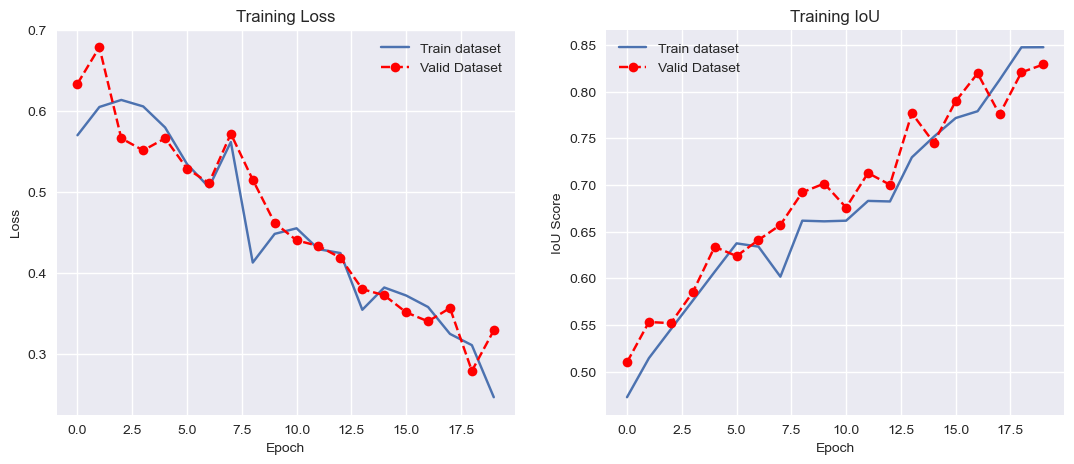

In [12]:

# Plotting the values
plt.style.use('seaborn')

plt.figure(figsize=(13, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(train_losses, label='Train dataset')
plt.plot(val_losses, '--r', marker='o', label='Valid Dataset')
plt.legend()

# Plot Training IoU
plt.subplot(1, 2, 2)
plt.title('Training IoU')
plt.plot(train_ious, label='Train dataset')
plt.plot(val_ious, '--r', marker='o', label='Valid Dataset')
plt.legend()

plt.show()

In [25]:
#Testing Loop
model.eval()
with torch.no_grad():
        val_loss = 0
        val_iou = 0
        for batch in test_dataloader:
            images, masks = batch
            inputs = processor(images=images, masks=masks, return_tensors="pt")

            # Move inputs to the correct device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)

            if "loss" in outputs:
                loss = outputs["loss"]
                val_loss += loss.item()
                predicted_Instance_map = processor.post_process_instance_segmentation(
                    outputs, target_sizes=[(224, 224)]
                )[0].cpu().numpy()

                ground_truth = masks.squeeze().cpu().numpy()
                iou = calculate_iou(predicted_Instance_map, ground_truth)
                val_iou += iou

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_iou = val_iou / len(val_dataloader)
        print(f"Test Loss: {avg_val_loss:.4f}, Test IoU: {avg_val_iou:.4f}")

Test Loss: 0.32433, Test IoU: 0.8254214


### Proposed Method: MaskTransformer with denosing

In [26]:
# Dataset and Dataloader
image_dir = "/content/Dataset/Preprocessed"
mask_dir = "/content/Dataset/Mask"

print("Checking directories...")
print(f"Images directory: {os.path.exists(image_dir)}, contains {len(os.listdir(image_dir))} files")
print(f"Masks directory: {os.path.exists(mask_dir)}, contains {len(os.listdir(mask_dir))} files")

# Define the transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = FloodDataset(image_dir=image_dir, mask_dir=mask_dir, image_transform=image_transform, mask_transform=mask_transform)

# Split dataset into training and validation sets
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Checking directories...
Images directory: True, contains 289 files
Masks directory: True, contains 289 files
Found 289 images with corresponding masks.
Sample of image files: ['3069.jpg', '21.jpg', '33.jpg', '1009.jpg', '3031.jpg']
Sample of corresponding mask files: ['/content/Dataset/Mask/3069.png', '/content/Dataset/Mask/21.png', '/content/Dataset/Mask/33.png', '/content/Dataset/Mask/1009.png', '/content/Dataset/Mask/3031.png']
